# Implementation of Variational Auto Encoders(VAE)

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np 
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.utils.tensorboard import SummaryWriter

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Loading LFWPeople Dataset

In [3]:
data_dir = './LFWPeople/'

train_dataset = torchvision.datasets.LFWPeople(root=data_dir, split='train', download=True)
test_dataset  = torchvision.datasets.LFWPeople(root=data_dir, split='test', download=True)

train_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Image Dimensions torch.Size([3, 256, 256])
Label: 2685


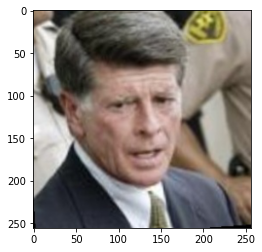

In [4]:
# Sample image in data
X, y = iter(train_loader).next()
plt.imshow(X[101].permute(1, 2, 0))
print(f"Image Dimensions {X[101].shape}")
print(f"Label: {y[101]}")

### Model

In [5]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims,depth=3, width=8):  
        super(VariationalEncoder, self).__init__()

        conv_layers = []
        in_channels = 3

        for i in range(depth):
          conv_layers.append(nn.Conv2d(in_channels, width, 3, stride=2, padding=1))
          in_channels = width
          if i == depth - 1: break
          conv_layers.append(nn.BatchNorm2d(width))
          conv_layers.append(nn.ReLU(True))
          width *= 2

        self.convs = nn.Sequential(*conv_layers)
        image_dimensions = 256 // (2**depth)
        
        self.linear1 = nn.Linear(in_channels * image_dimensions * image_dimensions, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.to(device)
        self.N.scale = self.N.scale.to(device)
        self.kl = 0

    def forward(self, x):
        x = x.to(device)
        x = self.convs(x)

        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dims, depth=3, width=8):
        super(Decoder, self).__init__()

        image_dimensions = 256 // (2**depth)
        in_channels = width * 2**(depth - 1)

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, in_channels * image_dimensions * image_dimensions),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(in_channels, image_dimensions, image_dimensions))

        conv_layers = []
        out_channels = in_channels // 2
        for i in range(depth - 1):
          conv_layers.append(nn.ConvTranspose2d(in_channels, out_channels, 3, stride=2, padding=1, output_padding=1))
          conv_layers.append(nn.BatchNorm2d(out_channels))
          conv_layers.append(nn.ReLU(True))
          in_channels = out_channels
          out_channels = out_channels // 2

        conv_layers.append(nn.ConvTranspose2d(in_channels, 3, 3, stride=2, padding=1, output_padding=1))

        self.convs = nn.Sequential(*conv_layers)
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.convs(x)
        x = torch.sigmoid(x)
        return x

In [7]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims, depth=3, width=8):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims, depth=depth, width=width)
        self.decoder = Decoder(latent_dims, depth=depth, width=width)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [8]:
d = 32
lr = 1e-3

depth = 3 # Number of convolutional layers in encoder and decoder
width = 8 # Number of kernels in first conv layer, halved for every subsequent layer

tensorboard_ts = 0

In [9]:
vae = VariationalAutoencoder(latent_dims=d, depth=depth, width=width).to(device)

In [10]:
summary(vae, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 128, 128]             224
       BatchNorm2d-2          [-1, 8, 128, 128]              16
              ReLU-3          [-1, 8, 128, 128]               0
            Conv2d-4           [-1, 16, 64, 64]           1,168
       BatchNorm2d-5           [-1, 16, 64, 64]              32
              ReLU-6           [-1, 16, 64, 64]               0
            Conv2d-7           [-1, 32, 32, 32]           4,640
            Linear-8                  [-1, 128]       4,194,432
            Linear-9                   [-1, 32]           4,128
           Linear-10                   [-1, 32]           4,128
VariationalEncoder-11                   [-1, 32]               0
           Linear-12                  [-1, 128]           4,224
             ReLU-13                  [-1, 128]               0
           Linear-14                [-

### Tensorboard

In [ ]:
%load_ext tensorboard

In [11]:
writer = SummaryWriter(filename_suffix=f"--depth-{depth}--width-{width}--demo")

In [ ]:
%tensorboard --logdir runs

### Training

In [12]:
optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

In [13]:
def train_epoch(vae, device, dataloader, optimizer):
    global tensorboard_ts

    vae.train()
    train_loss = 0.0
    for x, _ in dataloader: 
        x = x.to(device)
        x_hat = vae(x)
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f'\t Partial train loss (single batch): {loss.item()}')
        writer.add_scalar("Loss/Batch", loss.item(), tensorboard_ts)
        tensorboard_ts += 1
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [14]:
def test_epoch(vae, device, dataloader):
    vae.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            encoded_data = vae.encoder(x)
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [15]:
def plot_ae_outputs(encoder, decoder, n=10):
    plt.figure(figsize=(16,4.5))
    targets = np.array(test_dataset.targets)
    t_idx = { i:np.where(targets==i)[0][0] for i in list(np.random.choice(targets, n)) }

    for idx, i in enumerate(t_idx.keys()):
      ax = plt.subplot(2,n,idx+1)
      img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
      
      encoder.eval()
      decoder.eval()

      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img[0].permute(1,2,0).cpu().squeeze().numpy())
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      
      ax = plt.subplot(2, n, idx + 1 + n)
      plt.imshow(rec_img[0].permute(1,2,0).cpu().squeeze().numpy())  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      
    plt.show()  

	 Partial train loss (single batch): 5047041.5
	 Partial train loss (single batch): 32693450.0
	 Partial train loss (single batch): 4952699.5
	 Partial train loss (single batch): 5030437.5
	 Partial train loss (single batch): 4933840.5
	 Partial train loss (single batch): 4665241.0
	 Partial train loss (single batch): 4810541.5
	 Partial train loss (single batch): 4716819.0
	 Partial train loss (single batch): 4670249.0
	 Partial train loss (single batch): 4612629.5
	 Partial train loss (single batch): 4557927.0
	 Partial train loss (single batch): 4534334.5
	 Partial train loss (single batch): 4398703.0
	 Partial train loss (single batch): 4335683.5
	 Partial train loss (single batch): 4462694.5
	 Partial train loss (single batch): 4498879.5
	 Partial train loss (single batch): 4379819.0
	 Partial train loss (single batch): 4248712.5
	 Partial train loss (single batch): 4212249.0
	 Partial train loss (single batch): 4131054.0
	 Partial train loss (single batch): 4162113.0
	 Partial tr

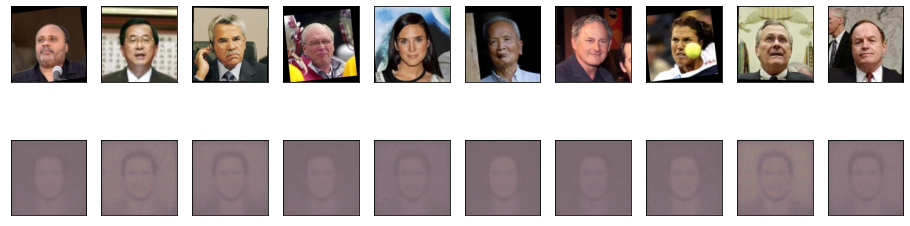

	 Partial train loss (single batch): 3855345.0
	 Partial train loss (single batch): 3873387.0
	 Partial train loss (single batch): 3752184.5
	 Partial train loss (single batch): 3744791.75
	 Partial train loss (single batch): 3658000.75
	 Partial train loss (single batch): 3490216.25
	 Partial train loss (single batch): 3632683.75
	 Partial train loss (single batch): 3555025.5
	 Partial train loss (single batch): 3535252.75
	 Partial train loss (single batch): 3444507.5
	 Partial train loss (single batch): 3393041.0
	 Partial train loss (single batch): 3432673.25
	 Partial train loss (single batch): 3297551.5
	 Partial train loss (single batch): 3212626.75
	 Partial train loss (single batch): 3305140.0
	 Partial train loss (single batch): 3338210.75
	 Partial train loss (single batch): 3145982.5
	 Partial train loss (single batch): 3103070.25
	 Partial train loss (single batch): 3063878.25
	 Partial train loss (single batch): 2984132.75
	 Partial train loss (single batch): 3002927.5
	 

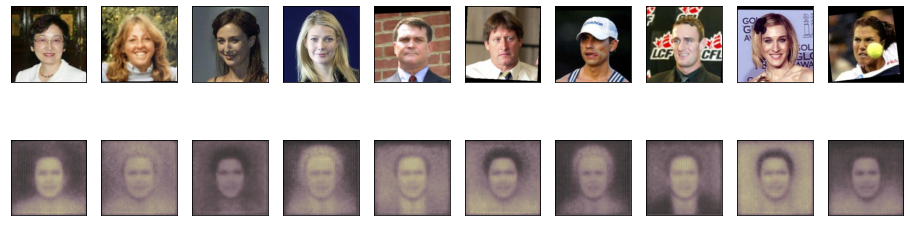

	 Partial train loss (single batch): 2722362.25
	 Partial train loss (single batch): 2761569.5
	 Partial train loss (single batch): 2686583.75
	 Partial train loss (single batch): 2641872.75
	 Partial train loss (single batch): 2595814.25
	 Partial train loss (single batch): 2522411.5
	 Partial train loss (single batch): 2631057.75
	 Partial train loss (single batch): 2566132.0
	 Partial train loss (single batch): 2574662.5
	 Partial train loss (single batch): 2546310.5
	 Partial train loss (single batch): 2470192.25
	 Partial train loss (single batch): 2519523.75
	 Partial train loss (single batch): 2452280.0
	 Partial train loss (single batch): 2412544.0
	 Partial train loss (single batch): 2460322.5
	 Partial train loss (single batch): 2490153.75
	 Partial train loss (single batch): 2342771.5
	 Partial train loss (single batch): 2324114.5
	 Partial train loss (single batch): 2326732.5
	 Partial train loss (single batch): 2277488.0
	 Partial train loss (single batch): 2296297.75
	 Pa

	 Partial train loss (single batch): 2131339.0
	 Partial train loss (single batch): 2171370.75
	 Partial train loss (single batch): 2147090.25
	 Partial train loss (single batch): 2092129.375
	 Partial train loss (single batch): 2081803.5
	 Partial train loss (single batch): 2050846.125
	 Partial train loss (single batch): 2121484.25
	 Partial train loss (single batch): 2058018.375
	 Partial train loss (single batch): 2074794.875
	 Partial train loss (single batch): 2068120.875
	 Partial train loss (single batch): 1991828.25
	 Partial train loss (single batch): 2046658.0
	 Partial train loss (single batch): 1988301.375
	 Partial train loss (single batch): 1991541.5
	 Partial train loss (single batch): 2024698.5
	 Partial train loss (single batch): 2054319.875
	 Partial train loss (single batch): 1928936.125
	 Partial train loss (single batch): 1910960.125
	 Partial train loss (single batch): 1946710.875
	 Partial train loss (single batch): 1893587.0
	 Partial train loss (single batch):

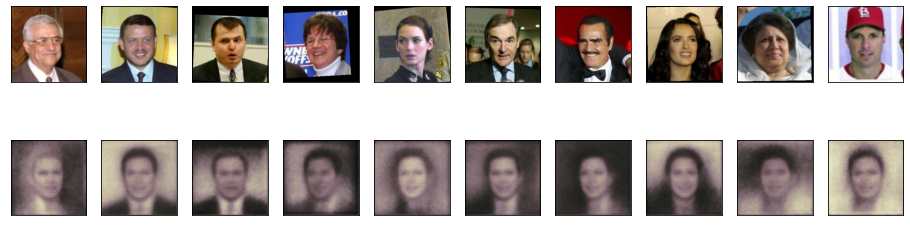

	 Partial train loss (single batch): 1809988.375
	 Partial train loss (single batch): 1851981.875
	 Partial train loss (single batch): 1843292.125
	 Partial train loss (single batch): 1795097.875
	 Partial train loss (single batch): 1809041.625
	 Partial train loss (single batch): 1786030.5
	 Partial train loss (single batch): 1851823.375
	 Partial train loss (single batch): 1797900.875
	 Partial train loss (single batch): 1799592.625
	 Partial train loss (single batch): 1830275.0
	 Partial train loss (single batch): 1743202.875
	 Partial train loss (single batch): 1801200.25
	 Partial train loss (single batch): 1748344.0
	 Partial train loss (single batch): 1775173.5
	 Partial train loss (single batch): 1789541.625
	 Partial train loss (single batch): 1809585.375
	 Partial train loss (single batch): 1708389.5
	 Partial train loss (single batch): 1699127.5
	 Partial train loss (single batch): 1715116.25
	 Partial train loss (single batch): 1693777.25
	 Partial train loss (single batch)

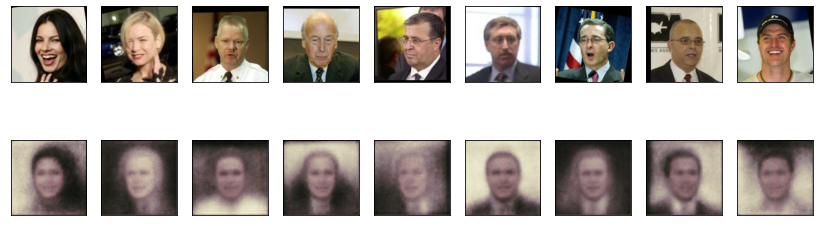

	 Partial train loss (single batch): 1641972.75
	 Partial train loss (single batch): 1680327.625
	 Partial train loss (single batch): 1665934.625
	 Partial train loss (single batch): 1625602.5
	 Partial train loss (single batch): 1640314.5
	 Partial train loss (single batch): 1636527.875
	 Partial train loss (single batch): 1685172.75
	 Partial train loss (single batch): 1632749.0
	 Partial train loss (single batch): 1650637.375
	 Partial train loss (single batch): 1685014.875
	 Partial train loss (single batch): 1605243.5
	 Partial train loss (single batch): 1650689.25
	 Partial train loss (single batch): 1608661.875
	 Partial train loss (single batch): 1645985.125
	 Partial train loss (single batch): 1650774.875
	 Partial train loss (single batch): 1667449.5
	 Partial train loss (single batch): 1572059.125
	 Partial train loss (single batch): 1561273.75
	 Partial train loss (single batch): 1590920.75
	 Partial train loss (single batch): 1566273.5
	 Partial train loss (single batch): 

	 Partial train loss (single batch): 1525934.375
	 Partial train loss (single batch): 1576030.25
	 Partial train loss (single batch): 1547300.125
	 Partial train loss (single batch): 1527351.125
	 Partial train loss (single batch): 1533902.0
	 Partial train loss (single batch): 1540715.625
	 Partial train loss (single batch): 1581710.25
	 Partial train loss (single batch): 1527412.0
	 Partial train loss (single batch): 1543619.125
	 Partial train loss (single batch): 1586758.25
	 Partial train loss (single batch): 1507436.875
	 Partial train loss (single batch): 1554569.375
	 Partial train loss (single batch): 1506071.5
	 Partial train loss (single batch): 1556923.875
	 Partial train loss (single batch): 1558609.75
	 Partial train loss (single batch): 1561109.125
	 Partial train loss (single batch): 1481652.875
	 Partial train loss (single batch): 1481526.25
	 Partial train loss (single batch): 1492891.5
	 Partial train loss (single batch): 1483592.0
	 Partial train loss (single batch)

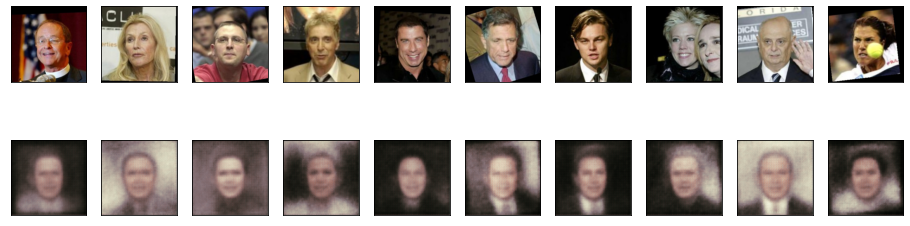

	 Partial train loss (single batch): 1446134.0
	 Partial train loss (single batch): 1473881.625
	 Partial train loss (single batch): 1481900.5
	 Partial train loss (single batch): 1434489.25
	 Partial train loss (single batch): 1454816.25
	 Partial train loss (single batch): 1466582.75
	 Partial train loss (single batch): 1505022.125
	 Partial train loss (single batch): 1459345.5
	 Partial train loss (single batch): 1469827.375
	 Partial train loss (single batch): 1515934.125
	 Partial train loss (single batch): 1438784.5
	 Partial train loss (single batch): 1479189.125
	 Partial train loss (single batch): 1445769.25
	 Partial train loss (single batch): 1497082.0
	 Partial train loss (single batch): 1489725.875
	 Partial train loss (single batch): 1498157.25
	 Partial train loss (single batch): 1422985.5
	 Partial train loss (single batch): 1407878.0
	 Partial train loss (single batch): 1442033.375
	 Partial train loss (single batch): 1420226.75
	 Partial train loss (single batch): 144

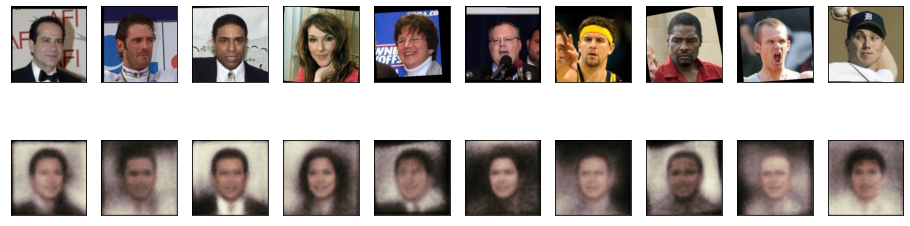

	 Partial train loss (single batch): 1369618.0
	 Partial train loss (single batch): 1418350.125
	 Partial train loss (single batch): 1418585.0
	 Partial train loss (single batch): 1377127.75
	 Partial train loss (single batch): 1402773.625
	 Partial train loss (single batch): 1421857.375
	 Partial train loss (single batch): 1441111.25
	 Partial train loss (single batch): 1396271.75
	 Partial train loss (single batch): 1419410.5
	 Partial train loss (single batch): 1458501.125
	 Partial train loss (single batch): 1387229.25
	 Partial train loss (single batch): 1431430.625
	 Partial train loss (single batch): 1394963.375
	 Partial train loss (single batch): 1439197.25
	 Partial train loss (single batch): 1448366.0
	 Partial train loss (single batch): 1430669.25
	 Partial train loss (single batch): 1375845.875
	 Partial train loss (single batch): 1368427.625
	 Partial train loss (single batch): 1387831.375
	 Partial train loss (single batch): 1380451.5
	 Partial train loss (single batch):

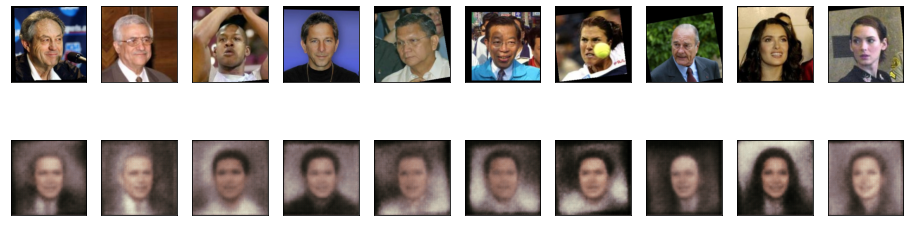

	 Partial train loss (single batch): 1335739.375
	 Partial train loss (single batch): 1372207.25
	 Partial train loss (single batch): 1372341.125
	 Partial train loss (single batch): 1341057.125
	 Partial train loss (single batch): 1367699.625
	 Partial train loss (single batch): 1371082.25
	 Partial train loss (single batch): 1409553.5
	 Partial train loss (single batch): 1356500.0
	 Partial train loss (single batch): 1379027.0
	 Partial train loss (single batch): 1412930.875
	 Partial train loss (single batch): 1357352.625
	 Partial train loss (single batch): 1385638.25
	 Partial train loss (single batch): 1353330.0
	 Partial train loss (single batch): 1407713.875
	 Partial train loss (single batch): 1392544.125
	 Partial train loss (single batch): 1396181.75
	 Partial train loss (single batch): 1334351.0
	 Partial train loss (single batch): 1323196.25
	 Partial train loss (single batch): 1354562.0
	 Partial train loss (single batch): 1334656.125
	 Partial train loss (single batch): 

	 Partial train loss (single batch): 1313618.875
	 Partial train loss (single batch): 1345524.125
	 Partial train loss (single batch): 1353970.75
	 Partial train loss (single batch): 1322613.0
	 Partial train loss (single batch): 1339059.125
	 Partial train loss (single batch): 1355336.0
	 Partial train loss (single batch): 1383053.0
	 Partial train loss (single batch): 1336404.125
	 Partial train loss (single batch): 1352222.875
	 Partial train loss (single batch): 1395443.25
	 Partial train loss (single batch): 1329766.0
	 Partial train loss (single batch): 1359969.5
	 Partial train loss (single batch): 1324943.5
	 Partial train loss (single batch): 1387072.25
	 Partial train loss (single batch): 1363328.875
	 Partial train loss (single batch): 1361794.125
	 Partial train loss (single batch): 1306662.0
	 Partial train loss (single batch): 1297845.75
	 Partial train loss (single batch): 1316369.875
	 Partial train loss (single batch): 1321006.375
	 Partial train loss (single batch): 1

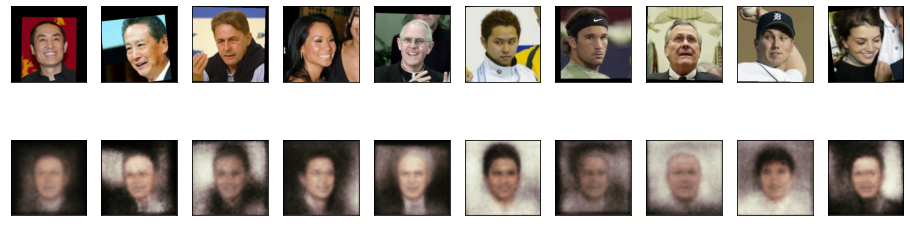

	 Partial train loss (single batch): 1263745.75
	 Partial train loss (single batch): 1309753.875
	 Partial train loss (single batch): 1313107.5
	 Partial train loss (single batch): 1283177.75
	 Partial train loss (single batch): 1300556.25
	 Partial train loss (single batch): 1321634.875
	 Partial train loss (single batch): 1343734.25
	 Partial train loss (single batch): 1290176.125
	 Partial train loss (single batch): 1313512.875
	 Partial train loss (single batch): 1354783.0
	 Partial train loss (single batch): 1289229.125
	 Partial train loss (single batch): 1319330.5
	 Partial train loss (single batch): 1286946.625
	 Partial train loss (single batch): 1347273.75
	 Partial train loss (single batch): 1332974.625
	 Partial train loss (single batch): 1319507.875
	 Partial train loss (single batch): 1277884.0
	 Partial train loss (single batch): 1260029.5
	 Partial train loss (single batch): 1298082.625
	 Partial train loss (single batch): 1275228.25
	 Partial train loss (single batch):

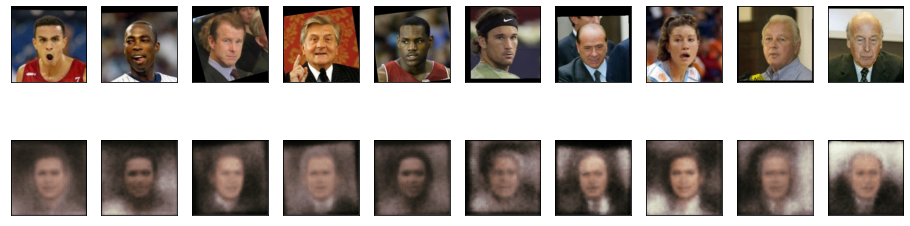

	 Partial train loss (single batch): 1235978.25
	 Partial train loss (single batch): 1265787.625
	 Partial train loss (single batch): 1281023.75
	 Partial train loss (single batch): 1246858.75
	 Partial train loss (single batch): 1263513.125
	 Partial train loss (single batch): 1296112.25
	 Partial train loss (single batch): 1301815.375
	 Partial train loss (single batch): 1267893.375
	 Partial train loss (single batch): 1285770.5
	 Partial train loss (single batch): 1316369.625
	 Partial train loss (single batch): 1265454.625
	 Partial train loss (single batch): 1298893.5
	 Partial train loss (single batch): 1252825.5
	 Partial train loss (single batch): 1331153.25
	 Partial train loss (single batch): 1317910.875
	 Partial train loss (single batch): 1291337.625
	 Partial train loss (single batch): 1255849.25
	 Partial train loss (single batch): 1241421.875
	 Partial train loss (single batch): 1274561.125
	 Partial train loss (single batch): 1267699.0
	 Partial train loss (single batch

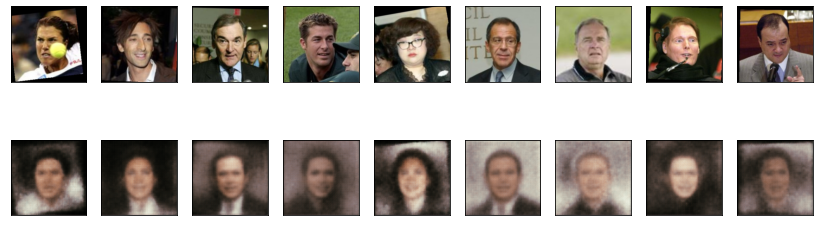

	 Partial train loss (single batch): 1216493.75
	 Partial train loss (single batch): 1257947.0
	 Partial train loss (single batch): 1255524.75
	 Partial train loss (single batch): 1224058.375
	 Partial train loss (single batch): 1249311.125
	 Partial train loss (single batch): 1271889.5
	 Partial train loss (single batch): 1281174.875
	 Partial train loss (single batch): 1245209.125
	 Partial train loss (single batch): 1257124.875
	 Partial train loss (single batch): 1302061.0
	 Partial train loss (single batch): 1252788.25
	 Partial train loss (single batch): 1266096.125
	 Partial train loss (single batch): 1247372.25
	 Partial train loss (single batch): 1314821.375
	 Partial train loss (single batch): 1282826.875
	 Partial train loss (single batch): 1295055.875
	 Partial train loss (single batch): 1225402.25
	 Partial train loss (single batch): 1221063.125
	 Partial train loss (single batch): 1272751.375
	 Partial train loss (single batch): 1229737.5
	 Partial train loss (single batc

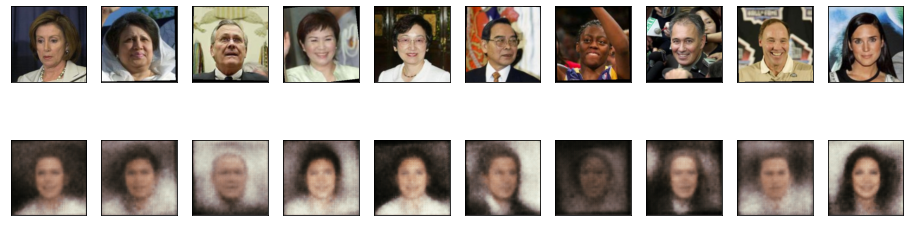

	 Partial train loss (single batch): 1206845.75
	 Partial train loss (single batch): 1233637.375
	 Partial train loss (single batch): 1236832.25
	 Partial train loss (single batch): 1213425.625
	 Partial train loss (single batch): 1232264.0
	 Partial train loss (single batch): 1258296.5
	 Partial train loss (single batch): 1262840.375
	 Partial train loss (single batch): 1233300.375
	 Partial train loss (single batch): 1252011.25
	 Partial train loss (single batch): 1262484.75
	 Partial train loss (single batch): 1230897.625
	 Partial train loss (single batch): 1277123.125
	 Partial train loss (single batch): 1220610.875
	 Partial train loss (single batch): 1288687.0
	 Partial train loss (single batch): 1278044.625
	 Partial train loss (single batch): 1252897.375
	 Partial train loss (single batch): 1220905.875
	 Partial train loss (single batch): 1202093.25
	 Partial train loss (single batch): 1226749.0
	 Partial train loss (single batch): 1218466.625
	 Partial train loss (single batc

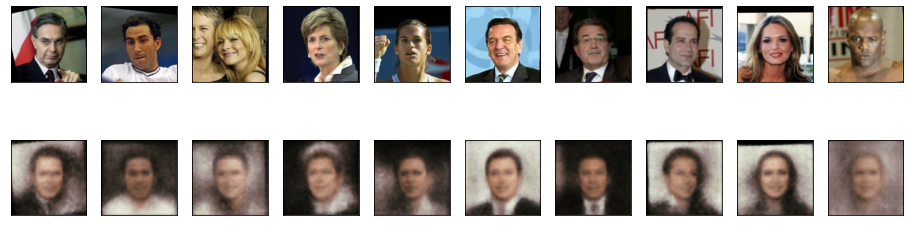

	 Partial train loss (single batch): 1167815.75
	 Partial train loss (single batch): 1214002.375
	 Partial train loss (single batch): 1215460.875
	 Partial train loss (single batch): 1190425.0
	 Partial train loss (single batch): 1208154.125
	 Partial train loss (single batch): 1236110.375
	 Partial train loss (single batch): 1257696.5
	 Partial train loss (single batch): 1209227.375
	 Partial train loss (single batch): 1218409.75
	 Partial train loss (single batch): 1263032.875
	 Partial train loss (single batch): 1212332.0
	 Partial train loss (single batch): 1236475.375
	 Partial train loss (single batch): 1199971.125
	 Partial train loss (single batch): 1270649.375
	 Partial train loss (single batch): 1273335.75
	 Partial train loss (single batch): 1245908.5
	 Partial train loss (single batch): 1185177.25
	 Partial train loss (single batch): 1197411.375
	 Partial train loss (single batch): 1226821.25
	 Partial train loss (single batch): 1202663.5
	 Partial train loss (single batch)

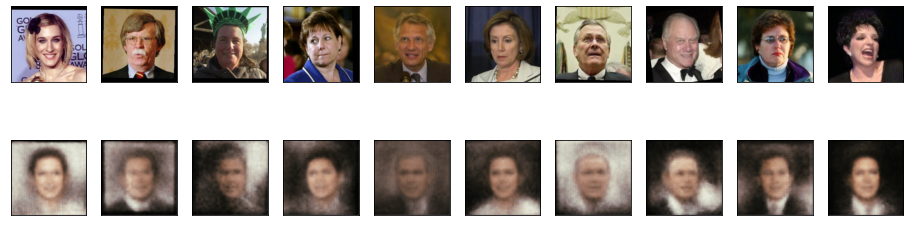

	 Partial train loss (single batch): 1168385.125
	 Partial train loss (single batch): 1203197.125
	 Partial train loss (single batch): 1199534.5
	 Partial train loss (single batch): 1176220.75
	 Partial train loss (single batch): 1198657.75
	 Partial train loss (single batch): 1236797.375
	 Partial train loss (single batch): 1235842.75
	 Partial train loss (single batch): 1197944.75
	 Partial train loss (single batch): 1207561.875
	 Partial train loss (single batch): 1249810.0
	 Partial train loss (single batch): 1203871.25
	 Partial train loss (single batch): 1228011.25
	 Partial train loss (single batch): 1192948.25
	 Partial train loss (single batch): 1262019.0
	 Partial train loss (single batch): 1247831.0
	 Partial train loss (single batch): 1225836.5
	 Partial train loss (single batch): 1182313.5
	 Partial train loss (single batch): 1186203.375
	 Partial train loss (single batch): 1208840.0
	 Partial train loss (single batch): 1181265.5
	 Partial train loss (single batch): 120885

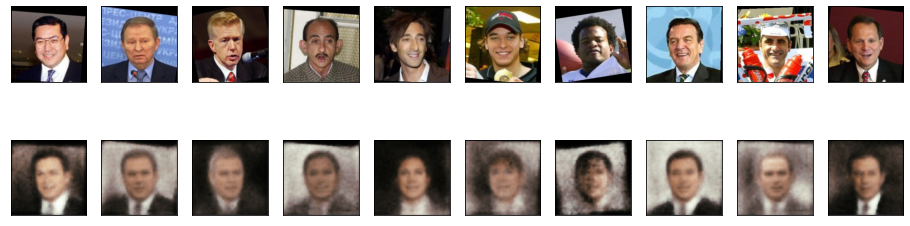

	 Partial train loss (single batch): 1147858.5
	 Partial train loss (single batch): 1191686.5
	 Partial train loss (single batch): 1189799.25
	 Partial train loss (single batch): 1162663.25
	 Partial train loss (single batch): 1185819.125
	 Partial train loss (single batch): 1213298.25
	 Partial train loss (single batch): 1213170.0
	 Partial train loss (single batch): 1181489.0
	 Partial train loss (single batch): 1197815.75
	 Partial train loss (single batch): 1225629.875
	 Partial train loss (single batch): 1182544.875
	 Partial train loss (single batch): 1206350.875
	 Partial train loss (single batch): 1174541.125
	 Partial train loss (single batch): 1248908.625
	 Partial train loss (single batch): 1230617.625
	 Partial train loss (single batch): 1205576.0
	 Partial train loss (single batch): 1155797.0
	 Partial train loss (single batch): 1170487.75
	 Partial train loss (single batch): 1199590.0
	 Partial train loss (single batch): 1171915.0
	 Partial train loss (single batch): 1190

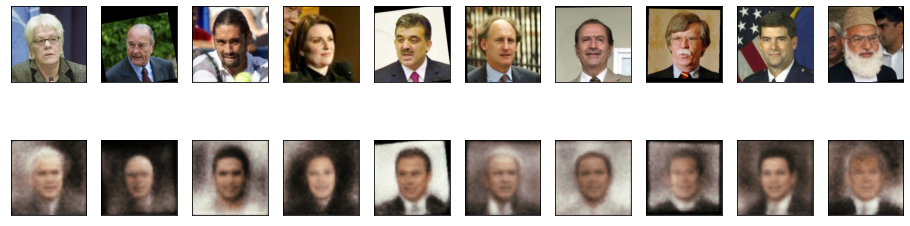

	 Partial train loss (single batch): 1132592.125
	 Partial train loss (single batch): 1169211.75
	 Partial train loss (single batch): 1160575.875
	 Partial train loss (single batch): 1145896.75
	 Partial train loss (single batch): 1164087.75
	 Partial train loss (single batch): 1194026.875
	 Partial train loss (single batch): 1201172.25
	 Partial train loss (single batch): 1157228.75
	 Partial train loss (single batch): 1168598.5
	 Partial train loss (single batch): 1213342.0
	 Partial train loss (single batch): 1167098.75
	 Partial train loss (single batch): 1185946.75
	 Partial train loss (single batch): 1150657.75
	 Partial train loss (single batch): 1234276.875
	 Partial train loss (single batch): 1206915.0
	 Partial train loss (single batch): 1172509.875
	 Partial train loss (single batch): 1148706.625
	 Partial train loss (single batch): 1147571.625
	 Partial train loss (single batch): 1160062.5
	 Partial train loss (single batch): 1147167.5
	 Partial train loss (single batch): 1

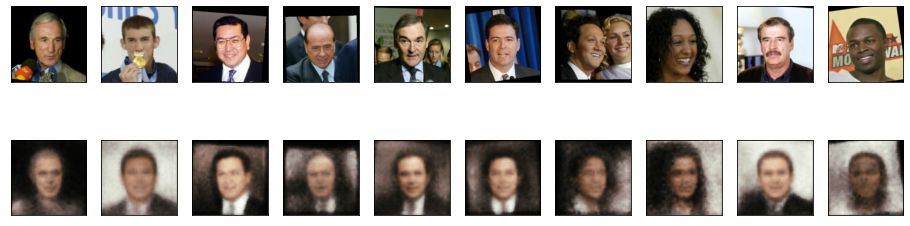

	 Partial train loss (single batch): 1117877.625
	 Partial train loss (single batch): 1150008.125
	 Partial train loss (single batch): 1154671.75
	 Partial train loss (single batch): 1128641.0
	 Partial train loss (single batch): 1151800.375
	 Partial train loss (single batch): 1183301.25
	 Partial train loss (single batch): 1176407.875
	 Partial train loss (single batch): 1147480.0
	 Partial train loss (single batch): 1163805.625
	 Partial train loss (single batch): 1189219.25
	 Partial train loss (single batch): 1142546.875
	 Partial train loss (single batch): 1176042.0
	 Partial train loss (single batch): 1152223.25
	 Partial train loss (single batch): 1203147.75
	 Partial train loss (single batch): 1184458.125
	 Partial train loss (single batch): 1170438.0
	 Partial train loss (single batch): 1129711.125
	 Partial train loss (single batch): 1126588.875
	 Partial train loss (single batch): 1140775.5
	 Partial train loss (single batch): 1128587.375
	 Partial train loss (single batch)

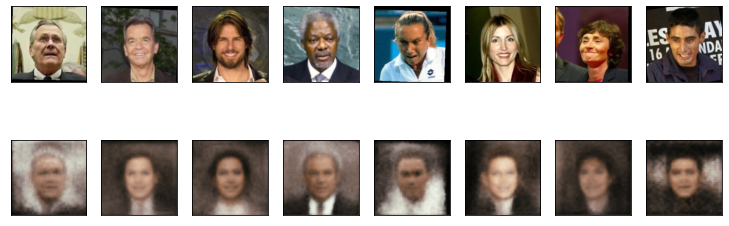

	 Partial train loss (single batch): 1099242.625
	 Partial train loss (single batch): 1122306.375
	 Partial train loss (single batch): 1135739.25
	 Partial train loss (single batch): 1120699.75
	 Partial train loss (single batch): 1123921.375
	 Partial train loss (single batch): 1170186.5
	 Partial train loss (single batch): 1181087.625
	 Partial train loss (single batch): 1132763.625
	 Partial train loss (single batch): 1155458.625
	 Partial train loss (single batch): 1186313.125
	 Partial train loss (single batch): 1141587.875
	 Partial train loss (single batch): 1171317.125
	 Partial train loss (single batch): 1148283.375
	 Partial train loss (single batch): 1212265.375
	 Partial train loss (single batch): 1186823.5
	 Partial train loss (single batch): 1170749.0
	 Partial train loss (single batch): 1136531.75
	 Partial train loss (single batch): 1117503.125
	 Partial train loss (single batch): 1148463.75
	 Partial train loss (single batch): 1140435.0
	 Partial train loss (single bat

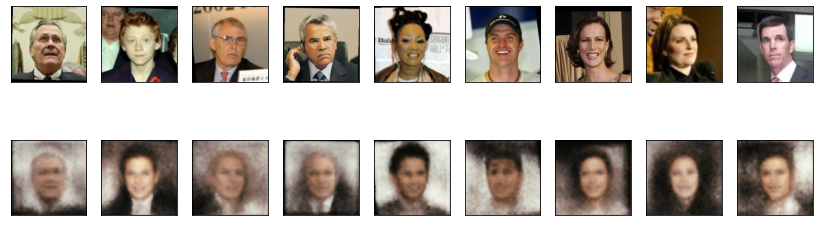

	 Partial train loss (single batch): 1085437.875
	 Partial train loss (single batch): 1123802.125
	 Partial train loss (single batch): 1123625.5
	 Partial train loss (single batch): 1099062.75
	 Partial train loss (single batch): 1124001.75
	 Partial train loss (single batch): 1163882.0
	 Partial train loss (single batch): 1160370.625
	 Partial train loss (single batch): 1126245.0
	 Partial train loss (single batch): 1140305.5
	 Partial train loss (single batch): 1161326.5
	 Partial train loss (single batch): 1134361.375
	 Partial train loss (single batch): 1164619.5
	 Partial train loss (single batch): 1116846.75
	 Partial train loss (single batch): 1188842.5
	 Partial train loss (single batch): 1188478.25
	 Partial train loss (single batch): 1163514.875
	 Partial train loss (single batch): 1106755.75
	 Partial train loss (single batch): 1114555.25
	 Partial train loss (single batch): 1137372.75
	 Partial train loss (single batch): 1115770.375
	 Partial train loss (single batch): 1141

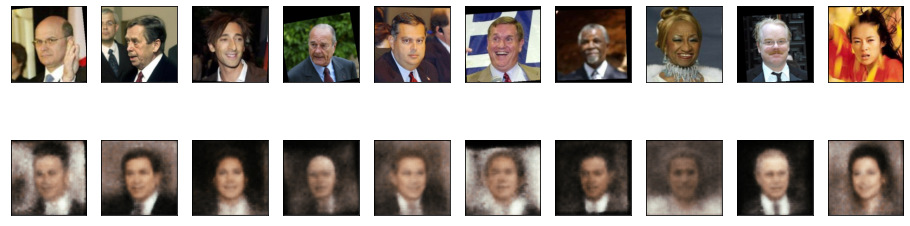

	 Partial train loss (single batch): 1081269.5
	 Partial train loss (single batch): 1120073.5
	 Partial train loss (single batch): 1111784.75
	 Partial train loss (single batch): 1084700.875
	 Partial train loss (single batch): 1107561.75
	 Partial train loss (single batch): 1155468.75
	 Partial train loss (single batch): 1169554.75
	 Partial train loss (single batch): 1117766.75
	 Partial train loss (single batch): 1116132.625
	 Partial train loss (single batch): 1167258.0
	 Partial train loss (single batch): 1130443.75
	 Partial train loss (single batch): 1140957.125
	 Partial train loss (single batch): 1115322.25
	 Partial train loss (single batch): 1198672.5
	 Partial train loss (single batch): 1176934.0
	 Partial train loss (single batch): 1139734.5
	 Partial train loss (single batch): 1111190.5
	 Partial train loss (single batch): 1123654.625
	 Partial train loss (single batch): 1146065.75
	 Partial train loss (single batch): 1114316.0
	 Partial train loss (single batch): 1123096

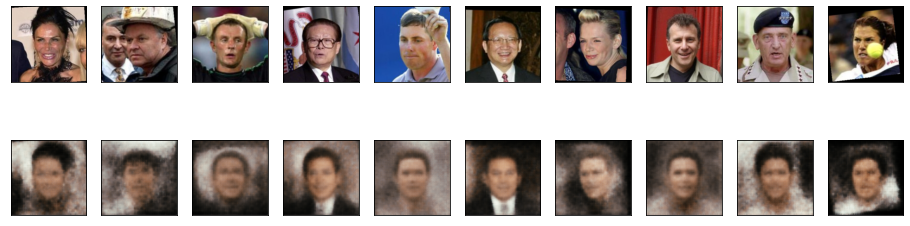

	 Partial train loss (single batch): 1075699.375
	 Partial train loss (single batch): 1112669.375
	 Partial train loss (single batch): 1112530.0
	 Partial train loss (single batch): 1082605.375
	 Partial train loss (single batch): 1113421.25
	 Partial train loss (single batch): 1147952.5
	 Partial train loss (single batch): 1136751.375
	 Partial train loss (single batch): 1108528.375
	 Partial train loss (single batch): 1125888.625
	 Partial train loss (single batch): 1146562.0
	 Partial train loss (single batch): 1111270.0
	 Partial train loss (single batch): 1142473.0
	 Partial train loss (single batch): 1106915.375
	 Partial train loss (single batch): 1176367.875
	 Partial train loss (single batch): 1149207.25
	 Partial train loss (single batch): 1129786.125
	 Partial train loss (single batch): 1107580.25
	 Partial train loss (single batch): 1104874.875
	 Partial train loss (single batch): 1114935.625
	 Partial train loss (single batch): 1098452.625
	 Partial train loss (single batc

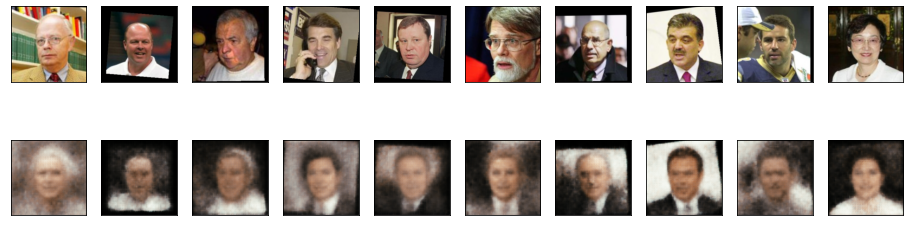

	 Partial train loss (single batch): 1059772.625
	 Partial train loss (single batch): 1094634.5
	 Partial train loss (single batch): 1101815.5
	 Partial train loss (single batch): 1080600.25
	 Partial train loss (single batch): 1105778.125
	 Partial train loss (single batch): 1141447.5
	 Partial train loss (single batch): 1134225.75
	 Partial train loss (single batch): 1103366.375
	 Partial train loss (single batch): 1123350.75
	 Partial train loss (single batch): 1143825.0
	 Partial train loss (single batch): 1101297.5
	 Partial train loss (single batch): 1143910.625
	 Partial train loss (single batch): 1101989.125
	 Partial train loss (single batch): 1155401.875
	 Partial train loss (single batch): 1152026.25
	 Partial train loss (single batch): 1135180.0
	 Partial train loss (single batch): 1097781.25
	 Partial train loss (single batch): 1090898.375
	 Partial train loss (single batch): 1107961.625
	 Partial train loss (single batch): 1096084.875
	 Partial train loss (single batch): 

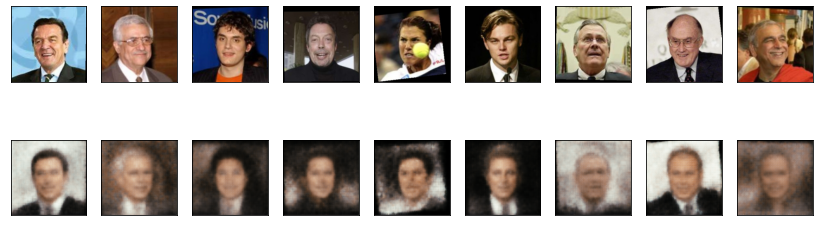

In [17]:
num_epochs = 25

for epoch in range(num_epochs):
   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print(f'\n EPOCH {epoch / 1}/{num_epochs} \t TRAIN LOSS {train_loss:.3f} \t VAL LOSS {val_loss:.3f}')
   writer.add_scalar("Loss/Train", train_loss, epoch)
   writer.add_scalar("Loss/Validation", val_loss, epoch)
   plot_ae_outputs(vae.encoder,vae.decoder,n=10)

### Evaluation

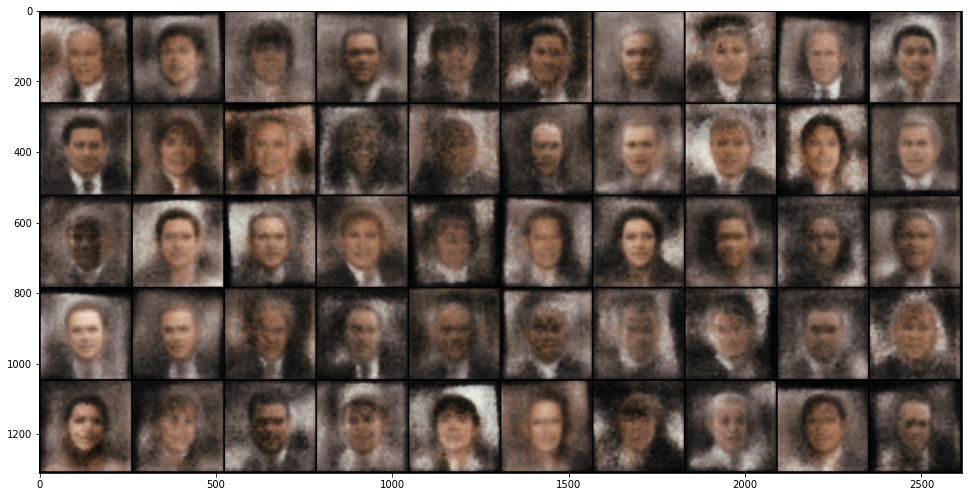

In [18]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

vae.eval()

with torch.no_grad():

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d, device=device)

    # reconstruct images from the latent vectors
    img_recon = vae.decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon.data[:50],10,5))
    plt.show()